In [1]:
import gc
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm

def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * smap

In [2]:
BASE = './'
census = pd.read_csv(BASE + 'census_starter.csv')
train = pd.read_csv(BASE + 'train.csv')
test = pd.read_csv(BASE + 'test.csv')
sub = pd.read_csv(BASE + 'sample_submission.csv')

In [3]:
census = pd.read_csv(BASE + 'census_starter.csv')
print(census.columns)
census.head()

Index(['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
       'pct_bb_2021', 'cfips', 'pct_college_2017', 'pct_college_2018',
       'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
       'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'],
      dtype='object')


,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [4]:
BASE_update = './12/'

In [5]:
reaveal_test = pd.read_csv(BASE_update + 'revealed_test.csv')
train = pd.concat([train, reaveal_test]).sort_values(by=['cfips','first_day_of_month']).reset_index()
drop_index = (test.first_day_of_month == '2022-11-01') | (test.first_day_of_month == '2022-12-01')
test = test.loc[~drop_index,:]
coords = pd.read_csv(BASE_update + 'cfips_location.csv')
print(train.shape, test.shape, sub.shape)

train['istest'] = 0
test['istest'] = 1
raw = pd.concat((train, test)).sort_values(['cfips','row_id']).reset_index(drop=True)
raw = raw.merge(coords.drop("name", axis=1), on="cfips")

raw['state_i1'] = raw['state'].astype('category')
raw['county_i1'] = raw['county'].astype('category')
raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
raw["dcount"] = raw.groupby(['cfips'])['row_id'].cumcount()
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]
raw['scale'] = (raw['first_day_of_month'] - raw['first_day_of_month'].min()).dt.days
raw['scale'] = raw['scale'].factorize()[0]
#raw['population'] = np.round(np.mean(raw['active']*100/raw['microbusiness_density']))

os.environ["CUDA_VISIBLE_DEVICES"]="0"
raw.tail(20)

(128535, 8) (18810, 3) (25080, 2)


,index,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,lng,lat,state_i1,county_i1,dcount,county_i,state_i,scale
147325,122253.0,56045_2021-11-01,56045,Weston County,Wyoming,2021-11-01,1.760374,98.0,0,-104.567404,43.840315,Wyoming,Weston County,27,3134,50,27
147326,122254.0,56045_2021-12-01,56045,Weston County,Wyoming,2021-12-01,1.796300,100.0,0,-104.567404,43.840315,Wyoming,Weston County,28,3134,50,28
147327,122255.0,56045_2022-01-01,56045,Weston County,Wyoming,2022-01-01,1.749688,98.0,0,-104.567404,43.840315,Wyoming,Weston County,29,3134,50,29
147328,122256.0,56045_2022-02-01,56045,Weston County,Wyoming,2022-02-01,1.749688,98.0,0,-104.567404,43.840315,Wyoming,Weston County,30,3134,50,30
147329,122257.0,56045_2022-03-01,56045,Weston County,Wyoming,2022-03-01,1.767542,99.0,0,-104.567404,43.840315,Wyoming,Weston County,31,3134,50,31
147330,122258.0,56045_2022-04-01,56045,Weston County,Wyoming,2022-04-01,1.767542,99.0,0,-104.567404,43.840315,Wyoming,Weston County,32,3134,50,32
147331,122259.0,56045_2022-05-01,56045,Weston County,Wyoming,2022-05-01,1.803249,101.0,0,-104.567404,43.840315,Wyoming,Weston County,33,3134,50,33
147332,122260.0,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101.0,0,-104.567404,43.840315,Wyoming,Weston County,34,3134,50,34
147333,122261.0,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101.0,0,-104.567404,43.840315,Wyoming,Weston County,35,3134,50,35
147334,122262.0,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100.0,0,-104.567404,43.840315,Wyoming,Weston County,36,3134,50,36


In [6]:
test.first_day_of_month.unique()

array(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
       '2023-05-01', '2023-06-01'], dtype=object)

In [7]:
raw.loc[raw.dcount==(40), :].reset_index(drop=True)

,index,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,lng,lat,state_i1,county_i1,dcount,county_i,state_i,scale
0,1.0,1001_2022-12-01,1001,Autauga County,Alabama,2022-12-01,3.470915,1475.0,0,-86.642900,32.535142,Alabama,Autauga County,40,0,0,40
1,3.0,1003_2022-12-01,1003,Baldwin County,Alabama,2022-12-01,8.250630,14133.0,0,-87.722745,30.727825,Alabama,Baldwin County,40,1,0,40
2,5.0,1005_2022-12-01,1005,Barbour County,Alabama,2022-12-01,1.252272,248.0,0,-85.391068,31.870090,Alabama,Barbour County,40,2,0,40
3,7.0,1007_2022-12-01,1007,Bibb County,Alabama,2022-12-01,1.287240,229.0,0,-87.126814,32.998376,Alabama,Bibb County,40,3,0,40
4,9.0,1009_2022-12-01,1009,Blount County,Alabama,2022-12-01,1.852060,822.0,0,-86.567006,33.980871,Alabama,Blount County,40,4,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,6261.0,56037_2022-12-01,56037,Sweetwater County,Wyoming,2022-12-01,2.876845,922.0,0,-108.879388,41.659762,Wyoming,Sweetwater County,40,3130,50,40
3131,6263.0,56039_2022-12-01,56039,Teton County,Wyoming,2022-12-01,26.314966,5043.0,0,-110.589698,43.934564,Wyoming,Teton County,40,3131,50,40
3132,6265.0,56041_2022-12-01,56041,Uinta County,Wyoming,2022-12-01,4.050703,588.0,0,-110.547405,41.287497,Wyoming,Uinta County,40,3132,50,40
3133,6267.0,56043_2022-12-01,56043,Washakie County,Wyoming,2022-12-01,3.060380,185.0,0,-107.682315,43.904378,Wyoming,Washakie County,40,3133,50,40


# There are some anomalies, specially at timestep 18

<AxesSubplot:xlabel='dcount'>

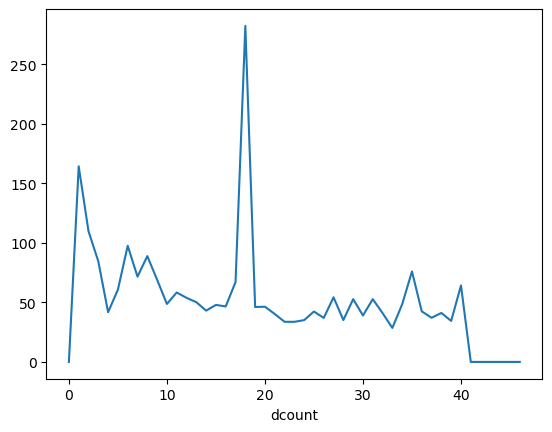

In [8]:
lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
raw['dif'] = raw['dif'].abs()
raw.groupby('dcount')['dif'].sum().plot()

In [9]:
outliers = []
cnt = 0
for o in tqdm(raw.cfips.unique()):
    indices = (raw['cfips']==o)
    tmp = raw.loc[indices].copy().reset_index(drop=True)
    var = tmp.microbusiness_density.values.copy()
    #vmax = np.max(var[:38]) - np.min(var[:38])
    
    for i in range(40, 0, -1):
        thr = 0.20*np.mean(var[:i])
        difa = abs(var[i]-var[i-1])
        if (difa>=thr):
            var[:i] *= (var[i]/var[i-1])
            outliers.append(o)
            cnt+=1
    var[0] = var[1]*0.99
    raw.loc[indices, 'microbusiness_density'] = var
    
outliers = np.unique(outliers)
len(outliers), cnt

  0%|          | 0/3135 [00:00<?, ?it/s]

C:\Users\82108\anaconda3\envs\py3715\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
C:\Users\82108\anaconda3\envs\py3715\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]
C:\Users\82108\anaconda3\envs\py3715\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


(552, 903)

In [10]:
'./'
Kmean_df = pd.read_csv(BASE + 'k_means_graph.csv') # 시간 오래걸려서 위에 4개 마크다운으로 바꾸고 따로 저장한 데이터 프레임 불러오기

In [11]:
Kmean_50 = pd.read_csv(BASE + 'k_means_graph_50.csv')
kmeans=Kmean_50[['cfips','K-means_Elbow']]
kmeans.columns = ['cfips','Elbow']

In [12]:
raw = raw.merge(Kmean_df[['cfips','K-means_Silhouette','K-means_Elbow']], on="cfips", how="left")
raw = raw.merge(kmeans[['cfips','Elbow']], on="cfips", how="left")
#feats += ['K-means_Silhouette','K-means_Elbow']

In [13]:
raw

,index,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,lng,...,county_i1,dcount,county_i,state_i,scale,mbd_lag_1,dif,K-means_Silhouette,K-means_Elbow,Elbow
0,0.0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,2.856021,1249.0,0,-86.642900,...,Autauga County,0,0,0,0,3.007682,0.000000,1,3,24
1,1.0,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,-86.642900,...,Autauga County,1,0,0,1,3.007682,0.040833,1,3,24
2,2.0,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,-86.642900,...,Autauga County,2,0,0,2,2.884870,0.059265,1,3,24
3,3.0,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,-86.642900,...,Autauga County,3,0,0,3,3.055843,0.020489,1,3,24
4,4.0,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,-86.642900,...,Autauga County,4,0,0,4,2.993233,0.000000,1,3,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,NaN,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,-104.567404,...,NaN,42,3134,50,42,NaN,0.000000,1,6,0
147341,NaN,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,-104.567404,...,NaN,43,3134,50,43,NaN,0.000000,1,6,0
147342,NaN,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,-104.567404,...,NaN,44,3134,50,44,NaN,0.000000,1,6,0
147343,NaN,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,-104.567404,...,NaN,45,3134,50,45,NaN,0.000000,1,6,0


In [14]:
values_list = [13101.0,48301.0,13265.0,28055.0,48033.0,48261.0,48269.0,31005.0,31009.0,31115.0,31165.0,48393.0,16033.0,31183.0,38087.0,2282.0,31007.0,31113.0,46003.0,46017.0]

<AxesSubplot:xlabel='dcount'>

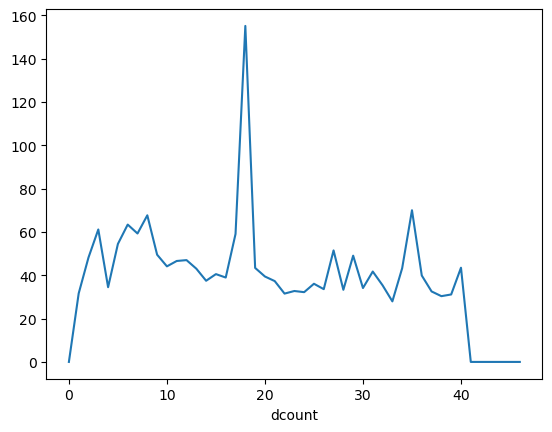

In [15]:
lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
raw['dif'] = raw['dif'].abs()
raw.groupby('dcount')['dif'].sum().plot()

# SMAPE is a relative metric so target must be converted.

In [16]:
raw['target'] = raw.groupby('cfips')['microbusiness_density'].shift(-1)
raw['target'] = raw['target']/raw['microbusiness_density'] - 1


raw.loc[raw['cfips']==28055, 'target'] = 0.0
raw.loc[raw['cfips']==48269, 'target'] = 0.0

raw.iloc[:20,:20]

,index,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,lng,lat,state_i1,county_i1,dcount,county_i,state_i,scale,mbd_lag_1,dif,K-means_Silhouette
0,0.0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,2.856021,1249.0,0,-86.6429,32.535142,Alabama,Autauga County,0,0,0,0,2.856021,0.000000,1
1,1.0,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,-86.6429,32.535142,Alabama,Autauga County,1,0,0,1,2.856021,0.010101,1
2,2.0,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,-86.6429,32.535142,Alabama,Autauga County,2,0,0,2,2.884870,0.059265,1
3,3.0,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,-86.6429,32.535142,Alabama,Autauga County,3,0,0,3,3.055843,0.020489,1
4,4.0,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,-86.6429,32.535142,Alabama,Autauga County,4,0,0,4,2.993233,0.000000,1
5,5.0,1001_2020-01-01,1001,Autauga County,Alabama,2020-01-01,2.969090,1242.0,0,-86.6429,32.535142,Alabama,Autauga County,5,0,0,5,2.993233,0.008066,1
6,6.0,1001_2020-02-01,1001,Autauga County,Alabama,2020-02-01,2.909326,1217.0,0,-86.6429,32.535142,Alabama,Autauga County,6,0,0,6,2.969090,0.020129,1
7,7.0,1001_2020-03-01,1001,Autauga County,Alabama,2020-03-01,2.933231,1227.0,0,-86.6429,32.535142,Alabama,Autauga County,7,0,0,7,2.909326,0.008217,1
8,8.0,1001_2020-04-01,1001,Autauga County,Alabama,2020-04-01,3.000167,1255.0,0,-86.6429,32.535142,Alabama,Autauga County,8,0,0,8,2.933231,0.022820,1
9,9.0,1001_2020-05-01,1001,Autauga County,Alabama,2020-05-01,3.004948,1257.0,0,-86.6429,32.535142,Alabama,Autauga County,9,0,0,9,3.000167,0.001594,1


<AxesSubplot:>

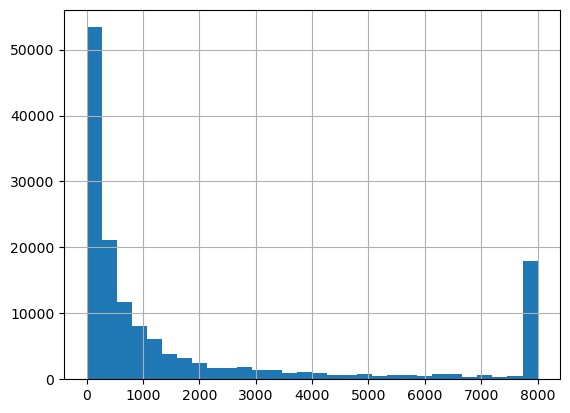

In [17]:
raw['lastactive'] = raw.groupby('cfips')['active'].transform('last')

dt = raw.loc[raw.dcount==40].groupby('cfips')['microbusiness_density'].agg('last')
raw['lasttarget'] = raw['cfips'].map(dt)

raw['lastactive'].clip(0, 8000).hist(bins=30)

# Feature Engineering

In [18]:
def build_features(raw, target='microbusiness_density', target_act='active_tmp', lags = 6):
    feats = []
    for lag in tqdm(range(1, lags)):
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)
        feats.append(f'mbd_lag_{lag}')
        feats.append(f'act_lag_{lag}')
        
    lag = 1
    for window in [2, 4, 6, 8, 10]:
        raw[f'mbd_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, min_periods=1).sum())        
        #raw[f'mbd_rollmea{window}_{lag}'] = raw[f'mbd_lag_{lag}'] - raw[f'mbd_rollmea{window}_{lag}']
        feats.append(f'mbd_rollmea{window}_{lag}')

        
    census_columns = list(census.columns)
    census_columns.remove( "cfips")
    
    raw = raw.merge(census, on="cfips", how="left")
    feats += census_columns
    
    
    
    return raw, feats

In [19]:
# Build Features based in lag of target
raw, feats = build_features(raw, 'target', 'active', lags = 5)
features = ['state_i']
features += feats
features += ['lng','lat']
print(features)
raw.loc[raw.dcount==40, features].head(10)

  0%|          | 0/4 [00:00<?, ?it/s]

['state_i', 'mbd_lag_1', 'act_lag_1', 'mbd_lag_2', 'act_lag_2', 'mbd_lag_3', 'act_lag_3', 'mbd_lag_4', 'act_lag_4', 'mbd_rollmea2_1', 'mbd_rollmea4_1', 'mbd_rollmea6_1', 'mbd_rollmea8_1', 'mbd_rollmea10_1', 'pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021', 'pct_college_2017', 'pct_college_2018', 'pct_college_2019', 'pct_college_2020', 'pct_college_2021', 'pct_foreign_born_2017', 'pct_foreign_born_2018', 'pct_foreign_born_2019', 'pct_foreign_born_2020', 'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018', 'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021', 'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019', 'median_hh_inc_2020', 'median_hh_inc_2021', 'lng', 'lat']


,state_i,mbd_lag_1,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_lag_4,act_lag_4,mbd_rollmea2_1,...,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,lng,lat
40,0,0.008202,12.0,-0.006114,3.0,0.006152,12.0,0.005498,20.0,0.002088,...,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,-86.642900,32.535142
87,0,-0.000848,-12.0,-0.012221,-187.0,0.002170,-156.0,-0.017601,-412.0,-0.013069,...,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0,-87.722745,30.727825
134,0,0.004049,1.0,0.012295,4.0,0.020921,9.0,0.008439,11.0,0.016344,...,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0,-85.391068,31.870090
181,0,0.008811,2.0,-0.008734,0.0,-0.021367,-5.0,0.017391,-1.0,0.000077,...,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0,-87.126814,32.998376
228,0,0.008589,7.0,0.002460,9.0,-0.010949,0.0,0.008589,7.0,0.011049,...,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0,-86.567006,33.980871
275,0,0.012500,1.0,0.025641,3.0,0.012987,4.0,0.013158,5.0,0.038141,...,0.5,0.3,0.2,29655,32152.0,37785,33866.0,29063.0,-85.715729,32.100459
322,0,0.005970,2.0,0.000000,2.0,0.009036,5.0,0.027864,14.0,0.005970,...,1.7,1.3,1.4,36326,39109.0,40688,44850.0,45236.0,-86.680409,31.752524
369,0,0.002808,7.0,-0.005981,-8.0,-0.003180,-16.0,0.007609,3.0,-0.003173,...,1.2,1.0,1.0,43686,45197.0,47255,50128.0,50977.0,-85.825747,33.771415
416,0,0.002571,1.0,0.018325,8.0,-0.040201,-8.0,-0.012407,-13.0,0.020895,...,2.1,2.3,1.8,37342,39872.0,42289,43875.0,47232.0,-85.391689,32.913666
463,0,0.008368,2.0,0.017021,6.0,-0.012605,3.0,0.000000,3.0,0.025390,...,1.2,0.9,0.4,40041,41014.0,41919,42509.0,43475.0,-85.603871,34.175887


In [20]:
ACT_THR = 140
ABS_THR = 0
TS = 40

In [21]:
train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR)  & (raw.lasttarget>ABS_THR) & (~raw['cfips'].isin(values_list))

In [22]:
#state=raw.groupby(['state'])['target'].mean()
#raw['state_m'] = raw['state'].map(state)

#features += ['state_m']
features += ['scale']
features += ['K-means_Silhouette','K-means_Elbow','Elbow']


In [23]:
raw.dcount.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], dtype=int64)

In [24]:
features.remove('state_i')

In [25]:
def get_model():
    from sklearn.ensemble import VotingRegressor
    import lightgbm as lgb
    import xgboost as xgb
    import catboost as cat
    from sklearn.pipeline import Pipeline
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.impute import KNNImputer
    
    params = {
    'n_iter': 200,
    'verbosity': -1,
    'objective': 'l1',
    'random_state': 42,
    'colsample_bytree': 0.8841279649367693,
    'colsample_bynode': 0.10142964450634374,
    'max_depth': 8,
    'learning_rate': 0.013647749926797374,
    'lambda_l1': 1.8386216853616875,
    'lambda_l2': 7.557660410418351,
    'num_leaves': 61,
    "seed": 42,
    'min_data_in_leaf': 213}

    lgb_model = lgb.LGBMRegressor(**params)
#     params = {
#         'objective': 'huber',
#         'metric': 'mae', 
#         "seed": 42,
#     }

#     lgb_model = lgb.LGBMRegressor(
#         n_estimators=1200,
#         learning_rate=0.075,
#         max_leaves = 31,
#         subsample=0.60,
#         colsample_bytree=0.50,
#         max_bin=4096,
#         l2=0.1,
#         **params
#     )
    
    xgb_model = xgb.XGBRegressor(
        objective='reg:pseudohubererror',
        #objective='reg:squarederror',
        tree_method="hist",
        n_estimators=795,
        learning_rate=0.0075,
        max_leaves = 17,
        subsample=0.50,
        colsample_bytree=0.50,
        max_bin=4096,
        n_jobs=2,
#         eval_metric='mae',
#         early_stopping_rounds=70,
    )
    
    cat_model = cat.CatBoostRegressor(
        iterations=1200,
        loss_function="MAPE",
        verbose=0,
#         objective="Huber",
        learning_rate=0.075,
        l2_leaf_reg=0.2,
#         max_leaves = 17,
        subsample=0.50,
        max_bin=4096,
#         delta=0.01
    )
    

    knn_model = Pipeline([
        ('imputer',  KNNImputer(n_neighbors=2)),
        ('knn', KNeighborsRegressor(5))
    ])
    
    return VotingRegressor([
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('cat', cat_model),
        ('knn', knn_model)
    ])
    

In [26]:
train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 19) & (raw.lastactive>ACT_THR)  & (raw.lasttarget>ABS_THR) & (~raw['cfips'].isin(values_list))

In [27]:
ACT_THR = 140
ABS_THR = 0
raw['ypred_last'] = np.nan
raw['ypred'] = np.nan
raw['k'] = 1.
VAL = []

for TS in range(39, 40):
    print(TS)
    #if TS != 37:
         #continue
    
    model = get_model()
            
    train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 19) & (raw.lastactive>ACT_THR)  & (raw.lasttarget>ABS_THR) & (~raw['cfips'].isin(values_list))
    valid_indices = (raw.istest==0) & (raw.dcount == TS) 
    model.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.0043, 0.0045),
        #raw.loc[train_indices, 'microbusiness_density'],
#         eval_set=[(raw.loc[valid_indices, features], raw.loc[valid_indices, 'target'])],
#         verbose=500,
    )

    ypred = model.predict(raw.loc[valid_indices, features])
    #raw.loc[valid_indices,'k'] = ypred
    raw.loc[valid_indices, 'k'] = ypred + 1
    raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

    # Validate
    lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
    dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']
    
    df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
    df['pred'] = df['cfips'].map(dt)
    df['lastval'] = df['cfips'].map(lastval)
    
    
    df.loc[df['lastactive']<=ACT_THR, 'pred'] = (
        df.loc[df['lastactive']<=ACT_THR, 'pred'] +
        df.loc[df['lastactive']<=ACT_THR, 'lastval']
    )/2
    df.loc[df['lastval']<=ABS_THR, 'pred'] = (
        df.loc[df['lastval']<=ABS_THR, 'pred'] +
        df.loc[df['lastval']<=ABS_THR, 'lastval']
    )/2
    

    #df.loc[df['state'].isin(blacklist), 'pred'] = (df.loc[df['state'].isin(blacklist), 'lastval']+
                                                   #df.loc[df['state'].isin(blacklist), 'pred'])/2
    
    
    #df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = (df.loc[df['cfips'].isin(blacklistcfips), 'lastval']+
                                                   #df.loc[df['cfips'].isin(blacklistcfips), 'pred'])/2
        
        
    #df.loc[df['state'].isin(blacklist), 'pred'] = df.loc[df['state'].isin(blacklist), 'lastval']
                                                   
    
    
    df.loc[df['cfips'].isin(values_list), 'pred'] = df.loc[df['cfips'].isin(values_list), 'lastval']
                                                   
        
        
    raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
    raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values
    
    print(f'TS: {TS}')
    print('Last Value SMAPE:', smape(df['microbusiness_density'], df['lastval']) )
    print('SMAPE:', smape(df['microbusiness_density'], df['pred']))
    print()


ind = (raw.dcount>=30)&(raw.dcount<=40)
print( 'SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred'] ) )
print( 'Last Value SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred_last'] ) )


39


C:\Users\82108\AppData\Roaming\Python\Python37\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Warning] min_data_in_leaf is set=213, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=213
[LightGBM] [Warning] lambda_l1 is set=1.8386216853616875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8386216853616875
[LightGBM] [Warning] lambda_l2 is set=7.557660410418351, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.557660410418351
[LightGBM] [Warning] num_iterations is set=200, n_iter=200 will be ignored. Current value: num_iterations=200
TS: 39
Last Value SMAPE: nan
SMAPE: nan

SMAPE: nan
Last Value SMAPE: nan


In [28]:
# dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby('state')['error', 'error_last'].mean()
# dt['hit'] = dt['error'] - dt['error_last']
# dt = dt.sort_values('hit', ascending=True)
# dt

In [29]:
# dt.index[-8:]

In [30]:
# dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby('dcount')['error', 'error_last'].mean()
# dt['hit'] = dt['error'] - dt['error_last']
# dt = dt.sort_values('hit', ascending=False)
# dt.loc[dt['hit']>0]
# dt

In [31]:
# dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby(['cfips','dcount'])['error', 'error_last'].mean()
# dt['hit'] = dt['error'] - dt['error_last']
# dt = dt.sort_values('hit', ascending=False).reset_index()
# dt.loc[dt['hit']>0]
# dt

In [32]:
# dt.loc[dt['hit']>0].cfips.values[:300]

In [33]:
# dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby('cfips')['error', 'error_last'].mean()
# dt['hit'] = dt['error'] - dt['error_last']
# dt = dt.sort_values('hit', ascending=False)
# dt = dt.loc[dt['hit']>0.00]
# dt

In [34]:
# dt.index

In [35]:
'''
dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby(['cfips','dcount'])['error', 'error_last'].last()
dt['miss'] = dt['error'] > dt['error_last']
dt = dt.groupby('cfips')['miss'].mean()
dt = dt.loc[dt>=0.50]
dt.shape
'''

"\ndt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby(['cfips','dcount'])['error', 'error_last'].last()\ndt['miss'] = dt['error'] > dt['error_last']\ndt = dt.groupby('cfips')['miss'].mean()\ndt = dt.loc[dt>=0.50]\ndt.shape\n"

In [36]:
#len(dt.index)

In [37]:
#','.join([str(i) for i in dt.index])

In [38]:
#for d in dt.index[:10]:
    #raw.loc[raw.cfips==d].plot(x='dcount', y=['microbusiness_density', 'ypred'], title=str(d))

In [39]:
# df = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].copy().reset_index(drop=True)
# print( smape(df['microbusiness_density'], df['ypred']) )

# dt = df.groupby(['cfips','dcount'])['error', 'error_last'].sum()
# dt['hit'] = 1*(dt['error'] < dt['error_last'])
# dt = dt.groupby('cfips')['hit'].mean().sort_values(ascending=True)

# toplist = list(dt.index[:800])
# #print(toplist)
# df.loc[df.cfips.isin(toplist), 'ypred'] = df.loc[df.cfips.isin(toplist), 'ypred_last']
# print( smape(df['microbusiness_density'], df['ypred']) )

In [40]:
#raw.iloc[-40:, :16]

In [41]:
raw.loc[raw.dcount==(41), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)

,cfips,microbusiness_density,state,lastactive,mbd_lag_1
0,1001,NaN,Alabama,1475.0,NaN
1,1003,NaN,Alabama,14133.0,NaN
2,1005,NaN,Alabama,248.0,NaN
3,1007,NaN,Alabama,229.0,NaN
4,1009,NaN,Alabama,822.0,NaN
...,...,...,...,...,...
3130,56037,NaN,Wyoming,922.0,NaN
3131,56039,NaN,Wyoming,5043.0,NaN
3132,56041,NaN,Wyoming,588.0,NaN
3133,56043,NaN,Wyoming,185.0,NaN


In [42]:
TS = 40
print(TS)

model0 = get_model()

train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 19) & (raw.lastactive>ACT_THR)  & (raw.lasttarget>ABS_THR) & (~raw['cfips'].isin(values_list))
valid_indices = (raw.dcount == TS)
model0.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.0044, 0.0046),
)
ypred = model0.predict(raw.loc[valid_indices, features])
raw.loc[valid_indices, 'k'] = ypred + 1.
raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

# Validate
lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']

40


C:\Users\82108\AppData\Roaming\Python\Python37\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Warning] min_data_in_leaf is set=213, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=213
[LightGBM] [Warning] lambda_l1 is set=1.8386216853616875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8386216853616875
[LightGBM] [Warning] lambda_l2 is set=7.557660410418351, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.557660410418351
[LightGBM] [Warning] num_iterations is set=200, n_iter=200 will be ignored. Current value: num_iterations=200


In [43]:
raw.loc[train_indices, features]

,mbd_lag_1,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_lag_4,act_lag_4,mbd_rollmea2_1,mbd_rollmea4_1,...,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,lng,lat,scale,K-means_Silhouette,K-means_Elbow,Elbow
19,0.012214,16.0,0.053902,83.0,-0.018422,70.0,-0.011802,55.0,0.066116,0.035892,...,58786.0,58731,57982.0,62660.0,-86.642900,32.535142,19,1,3,24
20,0.025641,34.0,0.012214,50.0,0.053902,117.0,-0.018422,104.0,0.037855,0.073334,...,58786.0,58731,57982.0,62660.0,-86.642900,32.535142,20,1,3,24
21,0.000735,1.0,0.025641,35.0,0.012214,51.0,0.053902,118.0,0.026376,0.092492,...,58786.0,58731,57982.0,62660.0,-86.642900,32.535142,21,1,3,24
22,-0.001470,-2.0,0.000735,-1.0,0.025641,33.0,0.012214,49.0,-0.000734,0.037121,...,58786.0,58731,57982.0,62660.0,-86.642900,32.535142,22,1,3,24
23,-0.003679,-5.0,-0.001470,-7.0,0.000735,-6.0,0.025641,28.0,-0.005149,0.021228,...,58786.0,58731,57982.0,62660.0,-86.642900,32.535142,23,1,3,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147286,0.031746,6.0,0.061798,17.0,-0.011111,15.0,-0.010989,13.0,0.093544,0.071444,...,53426.0,54158,57306.0,62271.0,-107.682315,43.904378,35,1,0,9
147287,-0.005128,-1.0,0.031746,5.0,0.061798,16.0,-0.011111,14.0,0.026618,0.077304,...,53426.0,54158,57306.0,62271.0,-107.682315,43.904378,36,1,0,9
147288,0.000000,0.0,-0.005128,-1.0,0.031746,5.0,0.061798,16.0,-0.005128,0.088416,...,53426.0,54158,57306.0,62271.0,-107.682315,43.904378,37,1,0,9
147289,-0.025773,-5.0,0.000000,-5.0,-0.005128,-6.0,0.031746,0.0,-0.025773,0.000845,...,53426.0,54158,57306.0,62271.0,-107.682315,43.904378,38,1,0,9


In [44]:
df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
df

,cfips,microbusiness_density,state,lastactive,mbd_lag_1
0,1001,NaN,Alabama,1475.0,NaN
1,1003,NaN,Alabama,14133.0,NaN
2,1005,NaN,Alabama,248.0,NaN
3,1007,NaN,Alabama,229.0,NaN
4,1009,NaN,Alabama,822.0,NaN
...,...,...,...,...,...
3130,56037,NaN,Wyoming,922.0,NaN
3131,56039,NaN,Wyoming,5043.0,NaN
3132,56041,NaN,Wyoming,588.0,NaN
3133,56043,NaN,Wyoming,185.0,NaN


In [45]:
df['pred'] = df['cfips'].map(dt)
df['lastval'] = df['cfips'].map(lastval)

#df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
#df.loc[df['lastval']<=ABS_THR, 'pred'] = df.loc[df['lastval']<=ABS_THR, 'lastval']
df.loc[df['lastactive']<=ACT_THR, 'pred'] = (
        df.loc[df['lastactive']<=ACT_THR, 'pred'] +
        df.loc[df['lastactive']<=ACT_THR, 'lastval']
    )/2
df.loc[df['lastval']<=ABS_THR, 'pred'] = (
        df.loc[df['lastval']<=ABS_THR, 'pred'] +
        df.loc[df['lastval']<=ABS_THR, 'lastval']
    )/2
#df.loc[df['state'].isin(blacklist), 'pred'] = df.loc[df['state'].isin(blacklist), 'lastval']
df.loc[df['cfips'].isin(values_list), 'pred'] = df.loc[df['cfips'].isin(values_list), 'lastval']
raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values

In [46]:
dt = raw.loc[raw.dcount==41, ['cfips', 'ypred']].set_index('cfips').to_dict()['ypred']
test = raw.loc[raw.istest==1, ['row_id', 'cfips','microbusiness_density']].copy()

In [47]:
test['microbusiness_density'] = test['cfips'].map(dt)

test = test[['row_id','microbusiness_density']]

In [48]:
sample_sub = pd.read_csv(BASE_update + 'revealed_test.csv')
sub_index = (sample_sub.first_day_of_month == '2022-11-01') | (sample_sub.first_day_of_month  == '2022-12-01')
test1 = pd.concat([sample_sub.loc[sub_index, :].drop([i for i  in sample_sub.columns if i !='row_id' and i != 'microbusiness_density'],axis=1).fillna(2), test])

In [49]:
test1[3135*2:]

,row_id,microbusiness_density
41,1001_2023-01-01,3.480373
42,1001_2023-02-01,3.480373
43,1001_2023-03-01,3.480373
44,1001_2023-04-01,3.480373
45,1001_2023-05-01,3.480373
...,...,...
147340,56045_2023-02-01,1.804022
147341,56045_2023-03-01,1.804022
147342,56045_2023-04-01,1.804022
147343,56045_2023-05-01,1.804022


In [50]:
test1 = test1.fillna(2)  # fill anything you want 

In [51]:
COLS = ['GEO_ID','NAME','S0101_C01_026E']
df2020 = pd.read_csv(BASE_update+'ACSST5Y2020.S0101-Data.csv',usecols=COLS)
df2020 = df2020.iloc[1:]
df2020['S0101_C01_026E'] = df2020['S0101_C01_026E'].astype('int')
print( df2020.shape )
df2020.head()

(3221, 3)


C:\Users\82108\anaconda3\envs\py3715\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (102) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,GEO_ID,NAME,S0101_C01_026E
1,0500000US01001,"Autauga County, Alabama",42496
2,0500000US01003,"Baldwin County, Alabama",171296
3,0500000US01005,"Barbour County, Alabama",19804
4,0500000US01007,"Bibb County, Alabama",17790
5,0500000US01009,"Blount County, Alabama",44383


In [52]:
df2021 = pd.read_csv(BASE_update+'ACSST5Y2021.S0101-Data.csv',usecols=COLS)
df2021 = df2021.iloc[1:]
df2021['S0101_C01_026E'] = df2021['S0101_C01_026E'].astype('int')
print( df2021.shape )
df2021.head()

(3221, 3)


C:\Users\82108\anaconda3\envs\py3715\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (102) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,GEO_ID,NAME,S0101_C01_026E
1,0500000US01001,"Autauga County, Alabama",44438
2,0500000US01003,"Baldwin County, Alabama",178105
3,0500000US01005,"Barbour County, Alabama",19995
4,0500000US01007,"Bibb County, Alabama",17800
5,0500000US01009,"Blount County, Alabama",45201


In [53]:
test1['cfips'] = test1.row_id.apply(lambda x: int(x.split('_')[0]))
#sub = sub.drop('cfips',axis=1)
#sub.to_csv('submission.csv',index=False)
test1.head()

,row_id,microbusiness_density,cfips
0,1001_2022-11-01,3.442677,1001
1,1001_2022-12-01,3.470915,1001
2,1003_2022-11-01,8.257636,1003
3,1003_2022-12-01,8.250630,1003
4,1005_2022-11-01,1.247223,1005


In [54]:
df2020['cfips'] = df2020.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
adult2020 = df2020.set_index('cfips').S0101_C01_026E.to_dict()

df2021['cfips'] = df2021.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
adult2021 = df2021.set_index('cfips').S0101_C01_026E.to_dict()

test1['adult2020'] = test1.cfips.map(adult2020)
test1['adult2021'] = test1.cfips.map(adult2021)
test1.head()

,row_id,microbusiness_density,cfips,adult2020,adult2021
0,1001_2022-11-01,3.442677,1001,42496,44438
1,1001_2022-12-01,3.470915,1001,42496,44438
2,1003_2022-11-01,8.257636,1003,171296,178105
3,1003_2022-12-01,8.250630,1003,171296,178105
4,1005_2022-11-01,1.247223,1005,19804,19995


In [55]:
Kmean_50 = pd.read_csv(BASE + 'k_means_graph_50.csv')
kmeans=Kmean_50[['cfips','K-means_Elbow']]
kmeans.columns = ['cfips','Elbow']
Elbow = kmeans.set_index('cfips').Elbow.to_dict()
test1['Elbow'] = test1.cfips.map(Elbow)

In [56]:
test1

,row_id,microbusiness_density,cfips,adult2020,adult2021,Elbow
0,1001_2022-11-01,3.442677,1001,42496,44438,24
1,1001_2022-12-01,3.470915,1001,42496,44438,24
2,1003_2022-11-01,8.257636,1003,171296,178105,24
3,1003_2022-12-01,8.250630,1003,171296,178105,24
4,1005_2022-11-01,1.247223,1005,19804,19995,4
...,...,...,...,...,...,...
147340,56045_2023-02-01,1.804022,56045,5601,5499,0
147341,56045_2023-03-01,1.804022,56045,5601,5499,0
147342,56045_2023-04-01,1.804022,56045,5601,5499,0
147343,56045_2023-05-01,1.804022,56045,5601,5499,0


In [57]:
test1.microbusiness_density = test1.microbusiness_density * test1.adult2020 / test1.adult2021
test1 = test1.drop(['adult2020','adult2021','cfips'],axis=1)

In [58]:
test1[['row_id','microbusiness_density']].to_csv('sub_test.csv',index=False)
test1.head()

,row_id,microbusiness_density,Elbow
0,1001_2022-11-01,3.292227,24
1,1001_2022-12-01,3.319231,24
2,1003_2022-11-01,7.941945,24
3,1003_2022-12-01,7.935207,24
4,1005_2022-11-01,1.235309,4


In [59]:
test1.reset_index()[3135*2:]

,index,row_id,microbusiness_density,Elbow
6270,41,1001_2023-01-01,3.328276,24
6271,42,1001_2023-02-01,3.328276,24
6272,43,1001_2023-03-01,3.328276,24
6273,44,1001_2023-04-01,3.328276,24
6274,45,1001_2023-05-01,3.328276,24
...,...,...,...,...
25075,147340,56045_2023-02-01,1.837485,0
25076,147341,56045_2023-03-01,1.837485,0
25077,147342,56045_2023-04-01,1.837485,0
25078,147343,56045_2023-05-01,1.837485,0


In [60]:
test1

,row_id,microbusiness_density,Elbow
0,1001_2022-11-01,3.292227,24
1,1001_2022-12-01,3.319231,24
2,1003_2022-11-01,7.941945,24
3,1003_2022-12-01,7.935207,24
4,1005_2022-11-01,1.235309,4
...,...,...,...
147340,56045_2023-02-01,1.837485,0
147341,56045_2023-03-01,1.837485,0
147342,56045_2023-04-01,1.837485,0
147343,56045_2023-05-01,1.837485,0


In [61]:
test1[3135*2:]

,row_id,microbusiness_density,Elbow
41,1001_2023-01-01,3.328276,24
42,1001_2023-02-01,3.328276,24
43,1001_2023-03-01,3.328276,24
44,1001_2023-04-01,3.328276,24
45,1001_2023-05-01,3.328276,24
...,...,...,...
147340,56045_2023-02-01,1.837485,0
147341,56045_2023-03-01,1.837485,0
147342,56045_2023-04-01,1.837485,0
147343,56045_2023-05-01,1.837485,0
